In [1]:
import time
import torch
import numpy as np
from scipy import linalg
import scipy.sparse as sp
from scipy.sparse.linalg import inv
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt
from torch.nn import functional as F
import torch.nn as nn
from scipy.sparse.linalg import spsolve
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def matrix_ofd4(nx, nz, h, f, delta, c_vec):
    # formulate the impedance matrix of velocity model by 4-order OFD method
    # 采用4阶OFD法建立速度模型阻抗矩阵
    # 2D rectangle area
    # implement PML condition all around: 4 directions
    # 实现PML条件四周：4个方向
    # last revision: 2021.4.20

    # parameter list
    # omega: angular frequency
    # h: spatial step
    # nx: number of nodes along x direction
    # nz: number of nodes along x direction
    # delta: PML layers

    # imaginary unit
    ii = 1j

    # problem scale
    N = (nx - 2) * (nz - 2)

    # nonzero elements of impedance matrix
    spn = 9 * (nx - 6) * (nz - 6) + 16 * (nx + nz - 12) + 14 * (nx + nz - 12) + 96

    # sparse store: vector space
    ai = np.zeros(spn, dtype=int)
    aj = np.zeros(spn, dtype=int)
    as_ = np.zeros(spn, dtype=complex)
    pa = 0

    # set angular frequency
    omega = 2 * np.pi * f

    # PML parameter: the ratio of reflection
    R = 1e-3

    for k in range(N):
        # grid coordinate conversion: row rule
        # 网格坐标转换：行规则
        j = k // (nx - 2)
        i = k - (nx - 2) * j

        # set velocity: row rule
        c = c_vec[k]

        # set PML attenuation function
        if i < delta - 1:
            dx = (
                    -3 * c / (2 * delta * h) * np.log(R) * ((delta - i - 1) / delta) ** 2
            )
            dxp = -3 * c / (delta * h) ** 2 * np.log(R) * (-(delta - i - 1) / delta)
        elif i > nx - delta - 2:
            dx = (
                    -3 * c / (2 * delta * h) * np.log(R) * ((i - nx + delta + 2) / delta) ** 2
            )
            dxp = -3 * c / (delta * h) ** 2 * np.log(R) * ((i - nx + delta + 2) / delta)
        else:
            dx = 0
            dxp = 0

        if j < delta - 1:
            dz = (
                    -3 * c / (2 * delta * h) * np.log(R) * ((delta - j - 1) / delta) ** 2
            )
            dzp = -3 * c / (delta * h) ** 2 * np.log(R) * (-(delta - j - 1) / delta)
        elif j > nz - delta - 2:
            dz = (
                    -3 * c / (2 * delta * h) * np.log(R) * ((j - nz + delta + 2) / delta) ** 2
            )
            dzp = -3 * c / (delta * h) ** 2 * np.log(R) * ((j - nz + delta + 2) / delta)
        else:
            dz = 0
            dzp = 0

        tx = 1 - ii * dx / omega
        tz = 1 - ii * dz / omega

        # matlab rule: index start from 1
        # matlab规则：指数从1开始
        kt = k + 1

        # 设置关于波场值 u 的行
        # left1
        if i != 0:
            ai[pa] = kt
            aj[pa] = kt - 1
            as_[pa] = 4 / (3 * tx ** 2) - 2 * ii * dxp * h / (3 * omega * tx ** 3)
            pa += 1

        # left2
        if i > 1:
            ai[pa] = kt
            aj[pa] = kt - 2
            as_[pa] = -1 / (12 * tx ** 2) + ii * dxp * h / (12 * omega * tx ** 3)
            pa += 1

        # right1
        if i != nx - 3:
            ai[pa] = kt
            aj[pa] = kt + 1
            as_[pa] = 4 / (3 * tx ** 2) + 2 * ii * dxp * h / (3 * omega * tx ** 3)
            pa += 1

        # right2
        if i < nx - 4:
            ai[pa] = kt
            aj[pa] = kt + 2
            as_[pa] = -1 / (12 * tx ** 2) - ii * dxp * h / (12 * omega * tx ** 3)
            pa += 1

        # up1
        if j != 0:
            ai[pa] = kt
            aj[pa] = kt - nx + 2
            as_[pa] = 4 / (3 * tz ** 2) - 2 * ii * dzp * h / (3 * omega * tz ** 3)
            pa += 1

        # up2
        if j > 1:
            ai[pa] = kt
            aj[pa] = kt - 2 * nx + 4
            as_[pa] = -1 / (12 * tz ** 2) + ii * dzp * h / (12 * omega * tz ** 3)
            pa += 1

        # down1
        if j != nz - 3:
            ai[pa] = kt
            aj[pa] = kt + nx - 2
            as_[pa] = 4 / (3 * tz ** 2) + 2 * ii * dzp * h / (3 * omega * tz ** 3)
            pa += 1

        # down2
        if j < nz - 4:
            ai[pa] = kt
            aj[pa] = kt + 2 * nx - 4
            as_[pa] = -1 / (12 * tz ** 2) - ii * dzp * h / (12 * omega * tz ** 3)
            pa += 1

        # inner
        ai[pa] = kt
        aj[pa] = kt
        as_[pa] = (omega * h / c) ** 2 - 5 / 2 * (1 / tx ** 2 + 1 / tz ** 2)
        pa += 1

    A = coo_matrix((as_, (ai - 1, aj - 1)), shape=(N, N)).tocsr()

    return A
def source_ofd(f, f0, N, h, c_vec, s_loc):
    # generate the right hand side term of source
    # last revision: 2022.7.6

    # initial unit
    ii = 1j

    # source location (count from 0)
    s0 = s_loc

    # source velocity
    sc = c_vec[s0][0]

    # Amplitude and phase
    t0 = 0.12
    Amp = 1e+5

    s = np.sqrt(2) * Amp / (np.pi * f0) * (f / f0) ** 2 * np.exp(-(f / f0) ** 2) * \
        sp.coo_matrix(([-h ** 2 / sc ** 2 * np.exp(-ii * 2 * np.pi * f * t0)], ([s0], [0])), shape=(N, 1))

    return s

In [3]:
import imageio
from scipy.sparse import diags
from scipy.sparse.linalg import splu,spilu
nx = 306
nz = 306
# spatial step
h = 0.025
# dominant frequency of source
f = 30
f0 = 10
# numbers of PML layers
delta = 10
# c_vec为波速
c0_mat = 4 * np.ones((nz - 2, nx - 2))  # 卷积层 输入30*30，输出30*30 dataset Unet编码解码 pytorch
cr1 = 4 * np.ones((nz - 2, nx - 2))
cr_mat = cr1
m, n = cr_mat.shape
c_vec = c0_mat.T.reshape(m * n, 1)
s_loc = int((nx-2)*(nz-4)/2+(nx-4)/2)
ss_loc = int((nx-2)*(nz-4)/4+(nx-4)/2)

A = matrix_ofd4(nx, nz, h, f, delta, c_vec)
N = A.shape[0]
b = source_ofd(f, f0, N, h, c_vec, s_loc).todense()
bb = source_ofd(f, f0, N, h, c_vec, ss_loc).todense()

In [4]:
def generate_random_data(num_samples, matrix):
    N = int(np.sqrt(matrix.shape[0]))
    noisy = 1e-6
    x_numpy = np.zeros((num_samples, 2, N, N))
    y_numpy = np.zeros((num_samples, 2, N, N))
    for i in range(num_samples):
        x_numpy[i,0,:,:] = 2*np.random.rand(N, N)-1
        x_numpy[i,1,:,:] = 2*np.random.rand(N, N)-1
        XX = (x_numpy[i,0,:,:] + 1j*x_numpy[i,1,:,:]).reshape(-1, 1)
        YY = matrix @ XX
        y_numpy[i,0,:,:] = YY.real.reshape(x_numpy[i,0,:,:].shape)
        y_numpy[i,1,:,:] = YY.imag.reshape(x_numpy[i,1,:,:].shape)
        power = np.max(np.abs(y_numpy[i]))
        x_numpy[i] = x_numpy[i]/power
        y_numpy[i] = y_numpy[i]/power
    return torch.tensor(x_numpy), torch.tensor(y_numpy)

In [5]:
trainX, trainY = generate_random_data(2100, A)
valX, valY = generate_random_data(10, A)
print(trainX.shape)
print(trainY.shape)
print(valX.shape)
print(valY.shape)
i = 1
x_np = (trainX[i,0,:,:] + 1j* trainX[i,1,:,:]).numpy()
y_np = (trainY[i,0,:,:] + 1j* trainY[i,1,:,:]).numpy()
erro = A @ x_np.reshape(-1,1) - y_np.reshape(-1,1)
print(np.linalg.norm(erro))

torch.Size([2100, 2, 304, 304])
torch.Size([2100, 2, 304, 304])
torch.Size([10, 2, 304, 304])
torch.Size([10, 2, 304, 304])
2.3271842954079067e-14


In [6]:
# Prepare data loaders
train_dataset = TensorDataset(trainY, trainX)
val_dataset = TensorDataset(valY, valX)
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

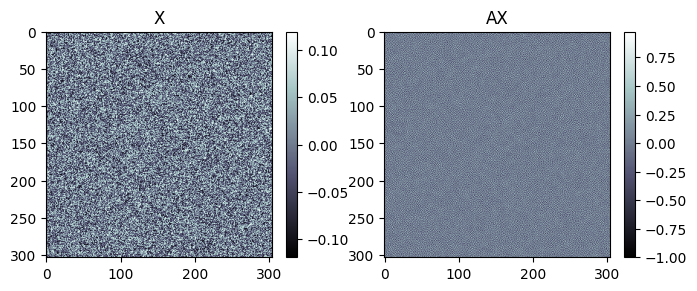

In [7]:
i = 5
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
im1 = axs[0].imshow(trainX[i,0,:,:], cmap='bone')
axs[0].set_title('X')
im2 = axs[1].imshow(trainY[i,1,:,:], cmap='bone')
axs[1].set_title('AX')
fig.colorbar(im1, ax=axs[0], shrink=0.732)
fig.colorbar(im2, ax=axs[1], shrink=0.732)

In [8]:
# 基本卷积块
class Conv(nn.Module):
    def __init__(self, C_in, C_out):
        super(Conv, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(C_in, C_out, 5, 1, 2),
            nn.Tanh(),
            nn.Conv2d(C_out, C_out, 5, 1, 2),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.layer(x)

# 下采样模块
class DownSampling(nn.Module):
    def __init__(self, C):
        super(DownSampling, self).__init__()
        self.Down = nn.Sequential(
            # 使用卷积进行2倍的下采样，通道数不变
            nn.Conv2d(C, C, 5, 2, 2),
            nn.Tanh()
        )
    def forward(self, x):
        return self.Down(x)

# 上采样模块
class UpSampling(nn.Module):
    def __init__(self, C):
        super(UpSampling, self).__init__()
        # 特征图大小扩大2倍，通道数减半
        self.Up = nn.Conv2d(C, C // 2, 1, 1)

    def forward(self, x, r):
        # 使用邻近插值进行下采样
        up = F.interpolate(x, scale_factor=2, mode="nearest")
        x = self.Up(up)
        # 拼接，当前上采样的，和之前下采样过程中的
        return torch.cat((x, r), 1)
# 主干网络
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # 4次下采样
        self.C1 = Conv(2, 64)
        self.D1 = DownSampling(64)
        self.C2 = Conv(64, 128)
        self.D2 = DownSampling(128)
        self.C3 = Conv(128, 256)
        self.D3 = DownSampling(256)
        self.C4 = Conv(256, 512)
        self.D4 = DownSampling(512)
        self.C5 = Conv(512, 1024)
        # 4次上采样
        self.U1 = UpSampling(1024)
        self.C6 = Conv(1024, 512)
        self.U2 = UpSampling(512)
        self.C7 = Conv(512, 256)
        self.U3 = UpSampling(256)
        self.C8 = Conv(256, 128)
        self.U4 = UpSampling(128)
        self.C9 = Conv(128, 64)

        self.Th = torch.nn.Tanh()
        self.pred = torch.nn.Conv2d(64, 2, 5, 1, 2)

    def forward(self, x):
        # 下采样部分
        R1 = self.C1(x)
        R2 = self.C2(self.D1(R1))
        R3 = self.C3(self.D2(R2))
        R4 = self.C4(self.D3(R3))
        Y1 = self.C5(self.D4(R4))
        # 上采样部分
        O1 = self.C6(self.U1(Y1, R4))
        O2 = self.C7(self.U2(O1, R3))
        O3 = self.C8(self.U3(O2, R2))
        O4 = self.C9(self.U4(O3, R1))
        return self.Th(self.pred(O4))

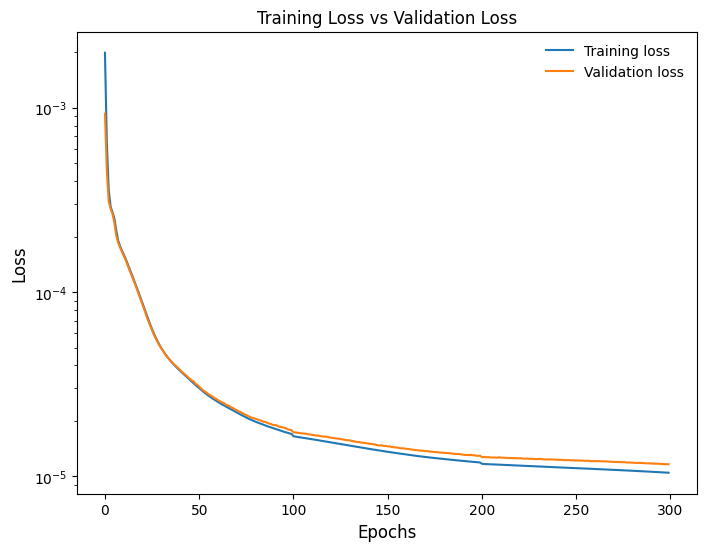

In [9]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Create the model
model = UNet()

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)
scheduler = StepLR(optimizer, step_size=100, gamma=0.5)

# Move model to the device specified above
model.to(device)

# Train the model
num_epochs = 300
total_step = len(train_loader)
         
# Initialize lists to monitor test loss and accuracy
train_loss = []
valid_loss = []

# Loop over the epochs
for epoch in range(num_epochs):
    # Initialize variables to monitor training and validation loss
    train_loss_epoch = 0
    valid_loss_epoch = 0

    model.train()
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.float().to(device)
        labels = labels.float().to(device)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Update the training loss
        train_loss_epoch += loss.item() * images.size(0)
    scheduler.step()
    
    model.eval()
    for i, (images, labels) in enumerate(val_loader):
        # Move tensors to the configured device
        images = images.float().to(device)
        labels = labels.float().to(device)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        # Update the validation loss
        valid_loss_epoch += loss.item() * images.size(0)

    # Calculate average losses
    train_loss_epoch = train_loss_epoch/len(train_loader.sampler)
    valid_loss_epoch = valid_loss_epoch/len(val_loader.sampler)
    train_loss.append(train_loss_epoch)
    valid_loss.append(valid_loss_epoch)
    
def predict(model, p):
    model.eval()
    tensor = np.random.rand(1, 2, 304, 304)
    tensor[0,0] = p.real.reshape(304, 304)
    tensor[0,1] = p.imag.reshape(304, 304)
    power = np.max(tensor)
    # Convert numpy array to torch tensor
    tensor = tensor/power
    tensor = torch.from_numpy(tensor).float().to(device)
    # Forward pass and get the output probabilities
    with torch.no_grad():
        output = model(tensor).cpu().numpy()
    pp = output[0,0] + 1j*output[0,1]
    matrix_p = (power*pp).reshape(304**2,)
    return matrix_p

# Plot training loss vs validation loss
plt.figure(figsize=(8,6))
plt.semilogy(train_loss, label='Training loss')
plt.semilogy(valid_loss, label='Validation loss')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss vs Validation Loss', fontsize=12)
plt.legend(frameon=False)
plt.show()

In [10]:
from numpy import inner, conjugate
from numpy.linalg import norm
from scipy.sparse.linalg import spsolve
from scipy.sparse.linalg.isolve.utils import make_system
import time

def bicgstab_solver(A, b, tol=None, x0=None, it_max=None, M=None):

    (A, _, x, b, postprocess) = make_system(A, None, x0, b)
    
    if tol == None:
        tol = 1e-5
    if it_max == None:
        it_max = len(b)+2
    matvec = A.matvec
    r = b - matvec(x)
    residuals = []
    normb = norm(b)
    normr = norm(r)/normb
    residuals.append(normr)
    get_res = lambda x: norm(matvec(x) - b)/norm(b)
    if normb == 0.0:
        normb = 1.0

    if normr < tol*normb:
        return (x, get_res(x), 0, residuals)
    r_copy = r.copy()
    p = r.copy()
    delta = (inner(r_copy.conjugate(), r))
    it = 0
    while True:
        if M is None:
            matrix_p = p
            A_matrix_p = matvec(p)
        else :    
            matrix_p = M.solve(p)
            A_matrix_p = matvec(matrix_p)
        alpha = (delta/inner(r_copy.conjugate(), A_matrix_p))
        s  = (r - alpha*A_matrix_p)
        if M is None:
            matrix_s = s
            A_matrix_s = matvec(s)
        else :
            matrix_s =  M.solve(s)
            A_matrix_s = matvec(matrix_s)
        omega = inner(A_matrix_s.conjugate(), s)/inner(A_matrix_s.conjugate(), A_matrix_s)
        x = x + alpha*matrix_p + omega*matrix_s
        r = s - omega*A_matrix_s
        delta_new = (inner(r_copy.conjugate(), r))
        if (delta == 0):
            print('Error: delta==0!')
            return (x, get_res(x), it, residuals)
        if (omega == 0):
            print('Error: omega==0!')
            return (x, get_res(x), it, residuals)
        beta = ((delta_new/delta) * (alpha/omega))
        delta = (delta_new)
        p = r + beta*(p - omega*A_matrix_p)
        it += 1
        normr = (norm(r)/normb)
        residuals.append(normr)
        if normr < tol:
            return (x, get_res(x), it, residuals)
        if it == it_max:
            return (x, get_res(x), it_max, residuals)
        pass
    pass
 
    
def bicgstab_model(A, b, mymodel, tol=None, x0=None, it_max=None, M=None):

    (A, _, x, b, postprocess) = make_system(A, None, x0, b)
    
    if tol == None:
        tol = 1e-5
    if it_max == None:
        it_max = 500
    matvec = A.matvec
    r = b - matvec(x)
    residuals = []
    normb = norm(b)
    normr = norm(r)/normb
    residuals.append(normr)
    get_res = lambda x: norm(matvec(x) - b)/norm(b)
    if normb == 0.0:
        normb = 1.0
    if normr < tol*normb:
        return (x, get_res(x), 0, residuals)
    r_copy = r.copy()
    p = r.copy()
    delta = (inner(r_copy.conjugate(), r))
    it = 0
    while True:

        matrix_p = predict(mymodel, p)
        A_matrix_p = matvec(matrix_p)
        alpha = (delta/inner(r_copy.conjugate(), A_matrix_p))
        s  = r - alpha*A_matrix_p

        matrix_s = predict(mymodel, s)
        A_matrix_s = matvec(matrix_s)
        omega = inner(A_matrix_s.conjugate(), s)/inner(A_matrix_s.conjugate(), A_matrix_s)
        x = (x + alpha*matrix_p + omega*matrix_s)
        r = (s - omega*A_matrix_s)
        delta_new = (inner(r_copy.conjugate(), r))
        if (delta == 0):
            print('Error: delta==0!')
            return (x, get_res(x), it, residuals)
        if (omega == 0):
            print('Error: omega==0!')
            return (x, get_res(x), it, residuals)
        beta = ((delta_new/delta) * (alpha/omega))
        delta = (delta_new)
        p = r + beta*(p - omega*A_matrix_p)
        it += 1
        normr = (norm(r)/normb)
        residuals.append(normr)
        if normr < tol:
            return (x, get_res(x), it, residuals)
        if it == it_max:
            return (x, get_res(x), it_max, residuals)
        pass
    pass

bicgstab: error: 6.967634033078568e-06 iter: 1295 time: 18.275278329849243
pbicgstab: error: 6.967634033078568e-06 iter: 1295 time: 18.92194938659668
vinnbicgstab: error: 9.66240779439882e-06 iter: 61 time: 10.463778972625732


Text(0, 0.5, 'Residual')

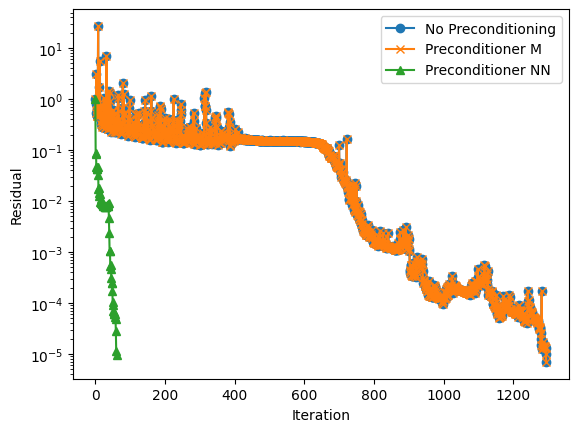

In [11]:
from scipy.sparse.linalg.dsolve import spilu
from scipy.sparse.linalg import bicgstab
import scipy.sparse as sp
from scipy.sparse.linalg import inv
#######  solve Ax = b system #######
N = A.shape[0]
### No preconditioning ###
start_time = time.time()
_, error,it, resdual = bicgstab_solver(A, b)
end_time = time.time() - start_time
print('bicgstab:', 'error:', error, 'iter:', it, 'time:', end_time)
# print('bicgstab:', 'error:', error, 'iter:', it, 'time:', elapsed)

### Preconditioning M ###
start_time = time.time()
_, error_pre,it_pre, resdual_pre = bicgstab_solver(A, b)
end_time_pre = time.time() - start_time
print('pbicgstab:', 'error:', error_pre, 'iter:', it_pre, 'time:', end_time_pre)

# ### Preconditioning NN ###
start_time = time.time()
x, error_nn,it_nn, resdual_nn = bicgstab_model(A, b, model)
end_time_nn = time.time() - start_time
print('vinnbicgstab:', 'error:', error_nn, 'iter:', it_nn, 'time:', end_time_nn)

### Plotting ###
plt.semilogy(resdual,marker='o')
plt.semilogy(resdual_pre,marker='x')
plt.semilogy(resdual_nn,marker='^')
plt.legend(['No Preconditioning','Preconditioner M','Preconditioner NN'])
plt.xlabel('Iteration')
plt.ylabel('Residual')

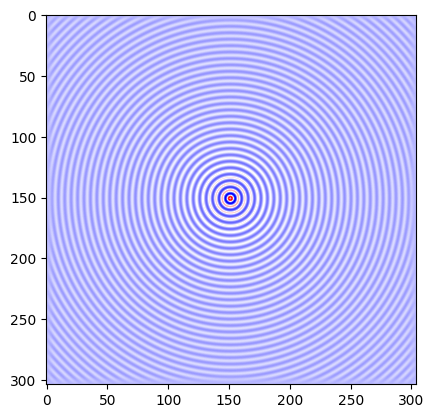

In [12]:
uu = x.reshape(nz-2, nx-2)
plt.imshow(uu.real, interpolation='spline16', cmap='bwr')

bicgstab: error: 9.829949485569443e-06 iter: 1596 time: 23.161300659179688
pbicgstab: error: 9.829949485569443e-06 iter: 1596 time: 22.304734230041504
vinnbicgstab: error: 9.49176748056022e-06 iter: 29 time: 5.08024525642395


Text(0, 0.5, 'Residual')

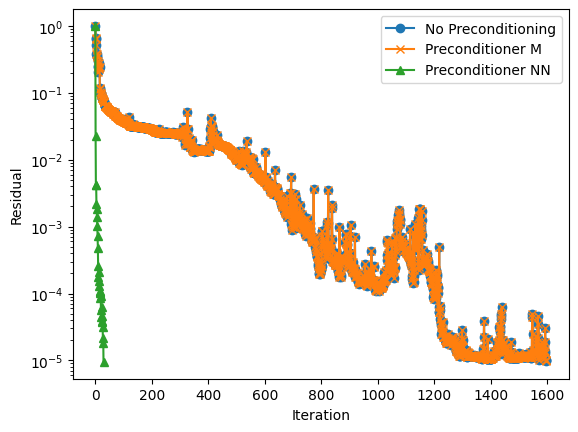

In [13]:
from scipy.sparse.linalg.dsolve import spilu
from scipy.sparse.linalg import bicgstab
import scipy.sparse as sp
from scipy.sparse.linalg import inv
#######  solve Ax = b system #######
### No preconditioning ###
start_time = time.time()
_, error,it, resdual = bicgstab_solver(A, bb)
end_time = time.time() - start_time
print('bicgstab:', 'error:', error, 'iter:', it, 'time:', end_time)
# print('bicgstab:', 'error:', error, 'iter:', it, 'time:', elapsed)

### Preconditioning M ###
start_time = time.time()
_, error_pre,it_pre, resdual_pre = bicgstab_solver(A, bb)
end_time_pre = time.time() - start_time
print('pbicgstab:', 'error:', error_pre, 'iter:', it_pre, 'time:', end_time_pre)

# ### Preconditioning NN ###
start_time = time.time()
xx, error_nn,it_nn, resdual_nn = bicgstab_model(A, bb, model)
end_time_nn = time.time() - start_time
print('vinnbicgstab:', 'error:', error_nn, 'iter:', it_nn, 'time:', end_time_nn)

### Plotting ###
plt.semilogy(resdual,marker='o')
plt.semilogy(resdual_pre,marker='x')
plt.semilogy(resdual_nn,marker='^')
plt.legend(['No Preconditioning','Preconditioner M','Preconditioner NN'])
plt.xlabel('Iteration')
plt.ylabel('Residual')

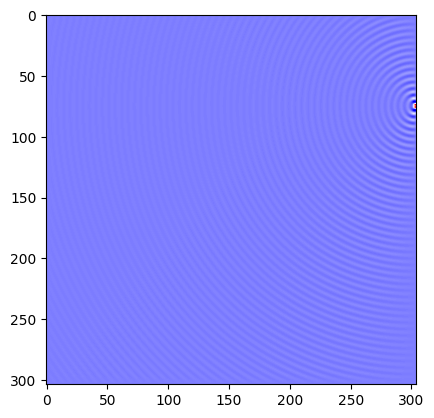

In [14]:
uu = xx.reshape(nz-2, nx-2)
plt.imshow(uu.real, interpolation='spline16', cmap='bwr')

In [15]:
torch.save(model.state_dict(),'net_params_f30.pth')